For the project, we will need various data about each song. That is: lyrics, some measure of popularity, genre, artist, and release date. Unfortunately, this information is not all available from the same source. We will be collecting data from Genius (a website for song analysis which houses genre and lyrics) and Spotify (A major streaming platform which tracks the total plays and current popularity of a track). This means that in their raw form, the data we receive will not be properly associated by song. We will have to correctly identify which songs correspond across the platforms, and then associate the relavent data into our database. We will have to be carefull to minimize error which may arise from this process, as that will significantly effect our final results.

First, lets take a look at the Genius API. We have to set up an authenticated account with Genius, so that it will respond to our API calls. We must identify our application and its purpose, and we will then be given a client_id and a client_secret which will allow us to make requests to the server.

For this, we will need an email an password. I didn't want to use mine, and it makes sense for everyone on the project to have access to the email should they require it when working on the API; thus, I made a new email for project purposes only.

Email: popularity.by.lyrics.analysis@gmail.com

Password: 2020uofudatascience

After creating the Genius account and registering a new API Client App, we have our ID and secret:

Client ID: f6xD9D1KtMiCZij5I-71axaKAN7G6NsuAtPcXzVLXenKdAyxZvmy9pMFBAvnP3j6
Client Secret: l8ducnbdIpED0rQNKpADr1M5x4_Q4qTuPvXQ7tC5X1p9D-vkiX2uqdQ-oGs9J48jr_sbueHofnB4thJigUrsZA

(Later, lets place this into a file which we access 'credientials.py')

Now that we have these, we need to perform an OAuth authentication process with the Genius API. This can be handled by a python package called rauth. The following cell installs rauth and imports it into the notebook.

In [1]:
%conda install rauth
%conda install selenium

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.

Note: you may need to restart the kernel to use updated packages.



PackagesNotFoundError: The following packages are not available from current channels:

  - rauth

Current channels:

  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


Above are some jupyter magic commands to install the rauth and selenium packages through anoconda. We will use these later. (If you don't have conda on the PATH, you will have to install manually). Below we are importing all of the packages we will use for the data collection process.

In [1]:
import requests
import json
import base64
from rauth import OAuth2Service
from selenium import webdriver
from bs4 import BeautifulSoup

In [54]:
#Create a variable to house the Genius authentication
genius = OAuth2Service(
    client_id = 'f6xD9D1KtMiCZij5I-71axaKAN7G6NsuAtPcXzVLXenKdAyxZvmy9pMFBAvnP3j6',
    client_secret = 'l8ducnbdIpED0rQNKpADr1M5x4_Q4qTuPvXQ7tC5X1p9D-vkiX2uqdQ-oGs9J48jr_sbueHofnB4thJigUrsZA',
    name = 'genius',
    authorize_url = 'https://api.genius.com/oauth/authorize',
    access_token_url = 'https://api.genius.com/oauth/token',
    base_url = 'https://api.genius.com/')

#Create a new session
access_token = 'qIcPSKG-IpOYMR0j-Y2NcuHVuGsbGHO3osa4b7BEJuFaBbZgDn26EKjl_whhxSjO'
session = genius.get_session(access_token)

In [131]:
#Make a simple request to the API
response = session.get('songs/2340619')

#Print the first 300 characters of the binary stream converted to string by utf-8 encoding
response.content.decode('utf-8')[:300]

'{"meta":{"status":200},"response":{"song":{"annotation_count":1,"api_path":"/songs/2340619","apple_music_id":null,"apple_music_player_url":"https://genius.com/songs/2340619/apple_music_player","description":{"dom":{"tag":"root","children":[{"tag":"p","children":["?"]}]}},"embed_content":"<div id=\'rg'

Looks like the song which we grabed was Chandelier by Sia. Lets explore the structure of this object ot find the data which we are looking for. The response we recieved is a JSON object, so we will need to convert it from the binary stream to a string, and then finally to a proper JSON object which we can use indexing on. To do this, we will import the json library.

In [132]:
json_object = json.loads(response.content.decode('utf-8'))
json_object

{'meta': {'status': 200},
 'response': {'song': {'annotation_count': 1,
   'api_path': '/songs/2340619',
   'apple_music_id': None,
   'apple_music_player_url': 'https://genius.com/songs/2340619/apple_music_player',
   'description': {'dom': {'tag': 'root',
     'children': [{'tag': 'p', 'children': ['?']}]}},
   'embed_content': "<div id='rg_embed_link_2340619' class='rg_embed_link' data-song-id='2340619'>Read <a href='https://genius.com/Med-meti-trainin-7-lyrics'>“Trainin' 7” by Med\xa0Meti</a> on Genius</div> <script crossorigin src='//genius.com/songs/2340619/embed.js'></script>",
   'featured_video': False,
   'full_title': "Trainin' 7 by\xa0Med\xa0Meti",
   'header_image_thumbnail_url': 'https://assets.genius.com/images/default_cover_image.png?1583526157',
   'header_image_url': 'https://assets.genius.com/images/default_cover_image.png?1583526157',
   'id': 2340619,
   'lyrics_owner_id': 2408984,
   'lyrics_state': 'complete',
   'path': '/Med-meti-trainin-7-lyrics',
   'pyongs_c

While there is a lot of data contained in the response object, it seems that it contains neither the lyrics of the song, nor the Genius tags (Tags are the system by which Genius identifies genres and sub-genres of a song). This data is available on their website, but as of now, there is no support for it within the API. What we can do, however, is use the API as a springboard for more traditional web-scraping. The response includes a url for the song, under which the tag and lyric information are housed. We can first use the api to get a url, and then proceed to the url and scrape the data we desire.

In [133]:
json_object['response']['song']['primary_artist']['name'].strip()

'Med Meti'

Navigating to https://genuis.com/Sia-chandelier-lyrics gives us the page for the song, and we can see the lyrics displayed, as well as the 'tags' (read genres) near the bottom of the page. Now, we can use the BeautifulSoup python package to scrape the html of this page. 

In [6]:
url = 'https://genius.com' + json_object['response']['song']['path']
page = requests.get(url)

In [7]:
html = BeautifulSoup(page.text, 'html.parser')
lyrics = html.find('div',class_='lyrics').get_text()
print(lyrics)



[Verse 1]
Party girls don't get hurt
Can't feel anything, when will I learn?
I push it down, push it down
I'm the one "for a good time call"
Phone's blowin' up, ringin' my doorbell
I feel the love, feel the love

[Pre-Chorus]
1 2 3, 1 2 3, drink
1 2 3, 1 2 3, drink
1 2 3, 1 2 3, drink
Throw 'em back till I lose count

[Chorus]
I'm gonna swing from the chandelier
From the chandelier
I'm gonna live like tomorrow doesn't exist
Like it doesn't exist
I'm gonna fly like a bird through the night
Feel my tears as they dry
I'm gonna swing from the chandelier
From the chandelier

[Post-Chorus]
But I'm holding on for dear life
Won't look down, won't open my eyes
Keep my glass full until morning light
'Cause I'm just holding on for tonight
Help me, I'm holding on for dear life
Won't look down, won't open my eyes
Keep my glass full until morning light
'Cause I'm just holding on for tonight
On for tonight

[Verse 2]
Sun is up, I'm a mess
Gotta get out now, gotta run from this
Here comes the shame,

As you can see, now we have data containing all of the lyrics for this song, scraped from the site. Now to try and find the genre tags.

In [9]:
meta = html.find('meta', itemprop='page_data')
json.loads(meta['content'])['dmp_data_layer']['page']['genres']

['Ballad', 'Reggae', 'R&B Genius', 'Electro-Pop', 'Pop Genius']

Unfortunately, it looks like that portion of the website is generated after the html is loaded, so while the browser can see it easily, our html files don't included. We have to change the way in which we recieved the html so that the our file is from after the javascript is run, and the data we want generated. To do this, we will be using a browser automation tool called selenium. The basic idea is that selenium will pretend to be a real browser (like Firefox or Chrome), and the webpage will appear to selenium just like if we veiwed it in the browser. This allows us to get the genre tags, which currently we can't see, since they are loaded in dynamically after the initial html file.

Now we can successfully gather the genres of each song from the Genius tagging system, which concludes all of the data which we are collecting from Genius. Now, we need to grab the Spotify hotness and number of listens. This requires another authentication process with OAuth2. Once again, we will use the rauth library to handle most of this. Requesting the authorization token, however, is a bit more involved, and Spotify requires that the request has specific body and headers. Because of this, we do that portion manually through the requests package.

In [2]:
spotify = OAuth2Service(
    client_id = 'f8ed44dea3354f30b7e49042cfbe1dd1',
    client_secret = 'ecfe526f97074cbf99680e6a09ee58a8',
    name = 'spotify',
    authorize_url = 'https://accounts.spotify.com/authorize',
    access_token_url = 'https://accounts.spotify.com/api/token',
    base_url = 'https://api.spotify.com')

In [30]:
encoded_client_id = base64.b64encode(bytes(spotify.client_id + ':' + spotify.client_secret,'utf-8'))
encoded_client_id = str(encoded_client_id,'utf-8')

authorization_id = 'Basic ' + encoded_client_id
header = {'Authorization' : authorization_id}
body = {'grant_type' : 'client_credentials'}
token = requests.post('https://accounts.spotify.com/api/token', data=body, headers=header).json()['access_token']
session = spotify.get_session(token)

In [4]:
json_object = session.get('/v1/tracks/4VrWlk8IQxevMvERoX08iC').json()
print(json_object['album']['uri'].split(':')[2])
json_object['popularity']
json_object['name']

3xFSl9lIRaYXIYkIn3OIl9


'Chandelier'

In [31]:
title = 'In my feelings'
artist = 'Drake'
spotify_id = None
#Search spotify by name and name + artist
for search in [title, title + ' ' + artist]:
    query_params = {'q' : search,
                'type' : 'track'}
    response = json.loads(session.get('v1/search', params=query_params).content)
    try:
        spotify_results = response['tracks']['items']
    except KeyError:
        try:
            print(response['error'])
            raise RuntimeError
        except KeyError:
            continue
    if spotify_results == []:
        continue
    for result in spotify_results:
        if verify_song_identity(result, title, artist):
            spotify_id = result['uri'].split(':')[2]
            break
print(spotify_id)

2G7V7zsVDxg1yRsu7Ew9RJ


In [26]:
json.loads(session.get('v1/search', params=query_params).content)

{'error': {'status': 401, 'message': 'The access token expired'}}

In [5]:
html = requests.get('https://t4ils.dev:4433/api/beta/albumPlayCount?albumid=3xFSl9lIRaYXIYkIn3OIl9')
for song in json.loads(html.content)['data']:
    if song['uri'] == 'spotify:track:' + '4VrWlk8IQxevMvERoX08iC':
        print(song['playcount'])

966554003


**Explain why we need to sometimes search for a track on spotify**

In [49]:
title = "I'll Be Home For Christmas"
artist = 'Carly Simon'
params = {'q': title + ' ' + artist,
         'type' : 'track'}
result = json.loads(session.get('v1/search', params=params).content)['tracks']['items']

In [52]:
"I'll Be Home For Christmas".strip().lower()

"i'll be home for christmas"

In [7]:
import re
def remove_post_hyphen(string):
    return string.split('-')[0].strip()

def remove_parenthesis(string):
    return string.split('(')[0].strip()

def alphise(string):
    return re.sub(r'\W+','',re.sub(r'\d+','',string))

def remove_the(string):
    return string.replace('The ','').strip()

def clean_string(string):
    return alphise(remove_post_hyphen(remove_parenthesis(remove_the(string))))

def verify_song_identity(song, name, artist):
    return (clean_string(song['name'].strip().lower()) == clean_string(name.strip().lower()) and clean_string(song['artists'][0]['name'].strip().lower()) == clean_string(artist.strip().lower()))

In [51]:
for res in result:
    if verify_song_identity(res, title,artist):
        print(res['uri'].split(':')[2])

05p4O4fK1hWChjZl3vfBgT


In [34]:
result = [{'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4FtSnMlCVxCswABUmdhwpm'}, 'href': 'https://api.spotify.com/v1/artists/4FtSnMlCVxCswABUmdhwpm', 'id': '4FtSnMlCVxCswABUmdhwpm', 'name': 'Carly Simon', 'type': 'artist', 'uri': 'spotify:artist:4FtSnMlCVxCswABUmdhwpm'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'SA', 'SE', 'SG', 'SK', 'SV', 'TH', 'TN', 'TR', 'TW', 'US', 'UY', 'VN', 'ZA'], 'external_urls': {'spotify': 'https://open.spotify.com/album/69A88XZpPSe8G0565hShLg'}, 'href': 'https://api.spotify.com/v1/albums/69A88XZpPSe8G0565hShLg', 'id': '69A88XZpPSe8G0565hShLg', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/ab67616d0000b2730ef39b10958dccff3ce2967e', 'width': 640}, {'height': 300, 'url': 'https://i.scdn.co/image/ab67616d00001e020ef39b10958dccff3ce2967e', 'width': 300}, {'height': 64, 'url': 'https://i.scdn.co/image/ab67616d000048510ef39b10958dccff3ce2967e', 'width': 64}], 'name': 'Christmas Is Almost Here', 'release_date': '2002-10-22', 'release_date_precision': 'day', 'total_tracks': 14, 'type': 'album', 'uri': 'spotify:album:69A88XZpPSe8G0565hShLg'}, 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4FtSnMlCVxCswABUmdhwpm'}, 'href': 'https://api.spotify.com/v1/artists/4FtSnMlCVxCswABUmdhwpm', 'id': '4FtSnMlCVxCswABUmdhwpm', 'name': 'Carly Simon', 'type': 'artist', 'uri': 'spotify:artist:4FtSnMlCVxCswABUmdhwpm'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'SA', 'SE', 'SG', 'SK', 'SV', 'TH', 'TN', 'TR', 'TW', 'US', 'UY', 'VN', 'ZA'], 'disc_number': 1, 'duration_ms': 144666, 'explicit': False, 'external_ids': {'isrc': 'USIR61200007'}, 'external_urls': {'spotify': 'https://open.spotify.com/track/05p4O4fK1hWChjZl3vfBgT'}, 'href': 'https://api.spotify.com/v1/tracks/05p4O4fK1hWChjZl3vfBgT', 'id': '05p4O4fK1hWChjZl3vfBgT', 'is_local': False, 'name': "I'll Be Home for Christmas", 'popularity': 6, 'preview_url': 'https://p.scdn.co/mp3-preview/b9b0a304380da1fd49f3762b6311001a392c7bb6?cid=f8ed44dea3354f30b7e49042cfbe1dd1', 'track_number': 7, 'type': 'track', 'uri': 'spotify:track:05p4O4fK1hWChjZl3vfBgT'}]

In [36]:
for res in result:
    if verify_song_identity(res,title,artist):
        print(res['uri'].split(':')[2])

05p4O4fK1hWChjZl3vfBgT


In [105]:
clean_string('Tab3ini 1')

'Tabini'

In [24]:
query_params = {'q' : 'Summers Over Interlude',
               'type' : 'track'}
spotify_results = json.loads(session.get('v1/search', params=query_params).content)['tracks']['items']

In [25]:
for res in spotify_results:
    if verify_song_identity(res,'Summers Over Interlude','Drake'):
        print(res['uri'].split(':')[2])
        break

3ppVO2tyWRRznNmONvt7Se


In [26]:
spotify_results

[{'album': {'album_type': 'album',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3TVXtAsR1Inumwj472S9r4'},
     'href': 'https://api.spotify.com/v1/artists/3TVXtAsR1Inumwj472S9r4',
     'id': '3TVXtAsR1Inumwj472S9r4',
     'name': 'Drake',
     'type': 'artist',
     'uri': 'spotify:artist:3TVXtAsR1Inumwj472S9r4'}],
   'available_markets': ['AD',
    'AE',
    'AR',
    'AT',
    'AU',
    'BE',
    'BG',
    'BH',
    'BO',
    'BR',
    'CA',
    'CH',
    'CL',
    'CO',
    'CR',
    'CY',
    'CZ',
    'DE',
    'DK',
    'DO',
    'DZ',
    'EC',
    'EE',
    'EG',
    'ES',
    'FI',
    'FR',
    'GB',
    'GR',
    'GT',
    'HK',
    'HN',
    'HU',
    'ID',
    'IE',
    'IL',
    'IS',
    'IT',
    'JO',
    'JP',
    'KW',
    'LB',
    'LI',
    'LT',
    'LU',
    'LV',
    'MA',
    'MC',
    'MT',
    'MX',
    'MY',
    'NI',
    'NL',
    'NO',
    'NZ',
    'OM',
    'PA',
    'PE',
    'PH',
    'PL',
    'PT',
    'PY',
    'QA',

**Talk about figuring out the valid genius ids**

In [178]:
import time
valid_ids = []
for i in range(1,5000000,301):
    try:
        response = session.get('songs/' + str(i))
        json_object = json.loads(response.content.decode('utf-8'))
        json_object['response']
        valid_ids.append(i)
    except KeyError:
        pass
    #maybe too little
    time.sleep(.05)

ConnectionError: ('Connection aborted.', OSError("(10054, 'WSAECONNRESET')"))

(array([280., 288., 211., 117., 188., 181.,  77., 154., 269., 295.]),
 array([1.000000e+00, 9.072240e+04, 1.814438e+05, 2.721652e+05,
        3.628866e+05, 4.536080e+05, 5.443294e+05, 6.350508e+05,
        7.257722e+05, 8.164936e+05, 9.072150e+05]),
 <a list of 10 Patch objects>)

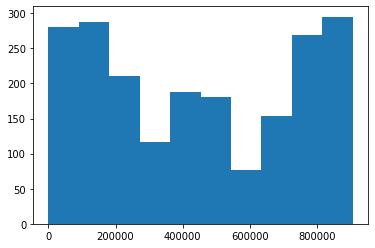

In [180]:
import matplotlib.pyplot as plt
plt.hist(valid_ids)

In [1]:
import pandas as pd
collected_data = pd.read_csv('data/data.csv')
collected_data

,title,artist,lyrics,listens,hotness,genres,genius ID,spotify ID
0,Summers Over Interlude,Drake,"\n\n[Intro: Majid Al Maskati]\nOoh, baby, yeah...",51595552,56,"['Interlude', 'R&B Genius', 'Canada', 'Rap Gen...",2463397,3ppVO2tyWRRznNmONvt7Se
1,Hard to Say I'm Sorry - 2009 Remaster,Chicago,\n\n[Verse 1]\nEverybody needs a little time a...,36747318,53,"['Eighties', 'Yacht Rock', 'Progressive Rock',...",1094995,5nDSJO4909uNzMcZH3CggS
2,Yokluğuma Alışma,No. 1,\n\n[Verse 1: No. 1]\nKafası bozuk saçmalıyor\...,1154536,44,"['Türkiye', 'Türkçe Sözlü Rap', 'Rap Genius', ...",3264702,7sKzxpsrivHioVArgWacZa
3,Las Cuatro Estaciones Op.8/3 - Invierno - Alle...,The Royal Vivaldi Symphony,\n\nInstrumental\n\n,610716,23,['Pop Genius'],2186582,3Y2eW1wWEHwLjTsEo1IrvW
4,Two A.M. Lovesick,Blue October,\n\nI walk like a burned out porn star\nWith a...,299038,22,['Pop Genius'],1407475,3qDADEJLyioOQuQuvGAG46
...,...,...,...,...,...,...,...,...
917,Cold Times,Zahr,\n\n(verse 1)\n\nLove for the substances I'm a...,17392,2,['R&B Genius'],3639586,6dqPec59XN9xwezRUcHf0K
918,Intro,Haikaiss,\n\n[Spoken Word: SPVIC]\nPronto\nEscolhe teu ...,227503,15,"['Brasil', 'Rap Genius']",2411391,0ZbNvtsyzZNfA8sefTC4sn
919,Revolution,Dope,\n\nIt's our time\nTo make a stand\nYou and me...,344902,21,['Pop Genius'],1312087,6e8HoZ0br0NyJAh49dptc6
920,Sheguey 12,Gradur,"\n\n[Intro]\nDans la vie, y'a deux types de né...",9950587,45,"['France', 'Rap Genius', 'French Rap']",361915,016CNVVPkGR7QA8oNRhPxL


In [26]:
len(collected_data)

404

Nice!